In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
sns.set()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
X = PCA(n_components=2).fit_transform(MinMaxScaler().fit_transform(df.iloc[:, 1:-1]))
Y = LabelEncoder().fit_transform(df.iloc[:, -1])

In [4]:
hidden_size = 20
learning_rate = 0.005
momentum = 0.8

W1 = np.random.randn(X.shape[1]) / np.sqrt(X.shape[1])
b1 = np.zeros((1, X.shape[1]))
gamma_W1 = np.ones(W1.shape[0])
beta_W1 = np.zeros(W1.shape[0])

W2 = np.random.randn(X.shape[1], hidden_size) / np.sqrt(X.shape[1])
b2 = np.zeros((1, hidden_size))
gamma_W2 = np.ones(W2.shape[1])
beta_W2 = np.zeros(W2.shape[1])

W3 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
b3 = np.zeros((1, 3))

In [5]:
def forward_batch_normalization(X, gamma, beta, epsilon = 1e-6):
    mean_X = np.mean(X, axis = 0)
    X_different = X - mean_X
    variance_X = np.mean(X_different ** 2, axis = 0)
    std_X = np.sqrt(variance_X + epsilon)
    inverse_std_X = 1 / std_X
    X_hat = X_different * inverse_std_X
    gamma_X = gamma * X_hat
    normalized = gamma_X + beta
    return normalized, (X_hat, X_different, inverse_std_X, std_X, variance_X)

def backward_batch_normalization(dnormalized, gamma, beta, cached, epsilon = 1e-6):
    X_hat, X_different, inverse_std_X, std_X, variance_X = cached
    dbeta = np.sum(dnormalized, axis=0)
    dgamma = np.sum(dnormalized * X_hat, axis=0)
    dX_hat = dnormalized * gamma
    dinverse_std_X = np.sum(dX_hat * X_different, axis=0)
    dX_different1 = dX_hat * inverse_std_X
    dstd_X = -1. /(std_X**2) * dinverse_std_X
    dvar = 0.5 * 1. / np.sqrt(variance_X + epsilon) * dstd_X
    dX_different2 = 2 * X_different * dstd_X
    dX1 = (dX_different1 + dX_different2)
    dmean_X = -1 * np.sum(dX_different1 + dX_different2, axis=0)
    dX2 =  np.ones((dnormalized.shape[0],dnormalized.shape[1])) * dmean_X / dnormalized.shape[0]
    return dX1 + dX2, dgamma, dbeta

In [6]:
def predict(inputs):
    z1 = inputs * W1 + b1
    a1 = np.tanh(z1)
    bn1 = forward_batch_normalization(a1, gamma_W1, beta_W1)
    z2 = a1.dot(W2) + b2
    a2 = np.tanh(z2)
    bn2 = forward_batch_normalization(a2, gamma_W2, beta_W2)
    z3 = a2.dot(W3) + b3
    exp_scores = np.exp(z3)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [7]:
def training(epoch):
    global W1,b1,W2,b2,W3,b3,gamma_W1,gamma_W2,beta_W1,beta_W2
    z1 = X * W1 + b1
    a1 = np.tanh(z1)
    bn1,cached1 = forward_batch_normalization(a1, gamma_W1, beta_W1)
    z2 = bn1.dot(W2) + b2
    a2 = np.tanh(z2)
    bn2, cached2 = forward_batch_normalization(a2, gamma_W2, beta_W2)
    z3 = bn2.dot(W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    accuracy = np.mean(np.argmax(probs,axis=1) == Y)
    delta4 = probs
    delta4[range(X.shape[0]), Y] -= 1
    dW3 = (a2.T).dot(delta4)
    db3 = np.sum(delta4, axis=0, keepdims=True)
    dbn2, dgamma_W2, dbeta_W2 = backward_batch_normalization(delta4.dot(W3.T), gamma_W2, beta_W2, cached2)
    delta3 = dbn2 * (1 - np.power(a2, 2))
    dW2 = (a1.T).dot(delta3)
    db2 = np.sum(delta3, axis=0, keepdims=True)
    dbn1, dgamma_W1, dbeta_W1 = backward_batch_normalization(delta3.dot(W2.T), gamma_W1, beta_W1, cached1)
    delta2 = dbn1 * (1 - np.power(a1, 2))
    dW1 = np.mean(np.dot(X.T, delta2),axis=0)
    db1 = np.sum(delta2, axis=0)
    W1 += -learning_rate * dW1
    b1 += -learning_rate * db1
    W2 += -learning_rate * dW2
    b2 += -learning_rate * db2
    W3 += -learning_rate * dW3
    b3 += -learning_rate * db3
    gamma_W2 += -learning_rate * dgamma_W2
    beta_W2 += -learning_rate * dbeta_W2
    gamma_W1 += -learning_rate * dgamma_W1
    beta_W1 += -learning_rate * dbeta_W1
    Z = np.argmax(predict(np.c_[xx.ravel(), yy.ravel()]),axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
    cont = plt.title('Gradient Descent Batch Normalization decision boundary, epoch %d, accuracy: %f'%(epoch+1, accuracy))
    return cont

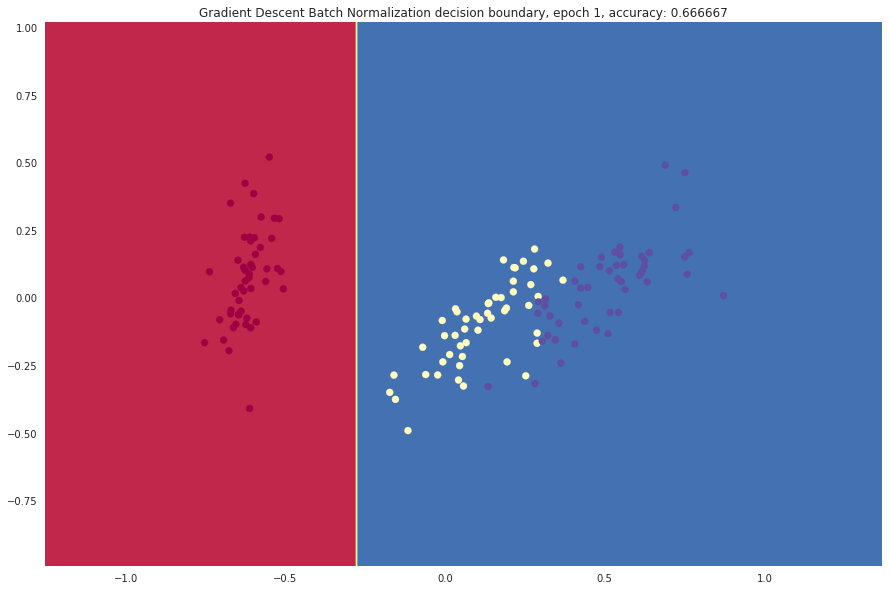

In [8]:
fig = plt.figure(figsize=(15,10))
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = np.argmax(predict(np.c_[xx.ravel(), yy.ravel()]),axis=1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
predicted= np.argmax(predict(X),axis=1)
accuracy = np.mean(Y == predicted)
plt.title('Gradient Descent Strategies Batch Normalization decision boundary, epoch %d, accuracy: %f'%(0, accuracy))
anim = animation.FuncAnimation(fig, training, frames=100, interval=200)
anim.save('animation-batch-normalization-iris.gif', writer='imagemagick', fps=5)